# Custom training: walkthrough

Based on this tutorial: [Custom training: walkthrough](https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough)

This notebook shows how to build a neural network model to classify  penguins species. 

## Setup

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

## Prerequisites

Make sure to install **TensorFlow Datasets** package which provides ready-to-use datasets. It handles downloading and preparing data and constructs [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) as a result.

Install:
```shell
poetry add tfds-nightly
```

# Meet the Penguins!

![Penguins!!!](https://allisonhorst.github.io/palmerpenguins/reference/figures/lter_penguins.png)

More about the [palmerpenguins](https://allisonhorst.github.io/palmerpenguins/) dataset. 

## Import Dataset

The default [penguins/processed](https://www.tensorflow.org/datasets/catalog/penguins) TensorFlow Dataset is already cleaned, normalized, and ready for building a model. Before you download the processed data, preview a simplified version to get familiar with the original penguin survey data.

## Preview the Data

Since the `penguins/processed` dataset is prepared, cleaned and so on, it makes sense to take a look at simplified version to get familiarized outselves with the data.

In [12]:
data_preview, info = tfds.load('penguins/simple', split='train', with_info=True)
df = tfds.as_dataframe(data_preview, info)

In [13]:
df[:5]

,body_mass_g,culmen_depth_mm,culmen_length_mm,flipper_length_mm,island,sex,species
0,4200.0,13.9,45.500000,210.0,0,0,2
1,4650.0,13.7,40.900002,214.0,0,0,2
2,5300.0,14.2,51.299999,218.0,0,1,2
3,5650.0,15.0,47.799999,215.0,0,1,2
4,5050.0,15.8,46.299999,215.0,0,1,2


In [14]:
df.describe()

,body_mass_g,culmen_depth_mm,culmen_length_mm,flipper_length_mm,island,sex,species
count,342.000000,342.000000,342.000000,342.000000,344.000000,344.000000,344.000000
mean,4201.754395,17.151171,43.921932,200.915207,0.662791,0.552326,0.918605
std,801.954529,1.974793,5.459584,14.061714,0.726194,0.558680,0.893320
min,2700.000000,13.100000,32.099998,172.000000,0.000000,0.000000,0.000000
25%,3550.000000,15.600000,39.224998,190.000000,0.000000,0.000000,0.000000
50%,4050.000000,17.299999,44.450001,197.000000,1.000000,1.000000,1.000000
75%,4750.000000,18.700001,48.500000,213.000000,1.000000,1.000000,2.000000
max,6300.000000,21.500000,59.599998,231.000000,2.000000,2.000000,2.000000


array([[<AxesSubplot: title={'center': 'body_mass_g'}>,
        <AxesSubplot: title={'center': 'culmen_depth_mm'}>,
        <AxesSubplot: title={'center': 'culmen_length_mm'}>],
       [<AxesSubplot: title={'center': 'flipper_length_mm'}>,
        <AxesSubplot: title={'center': 'island'}>,
        <AxesSubplot: title={'center': 'sex'}>],
       [<AxesSubplot: title={'center': 'species'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

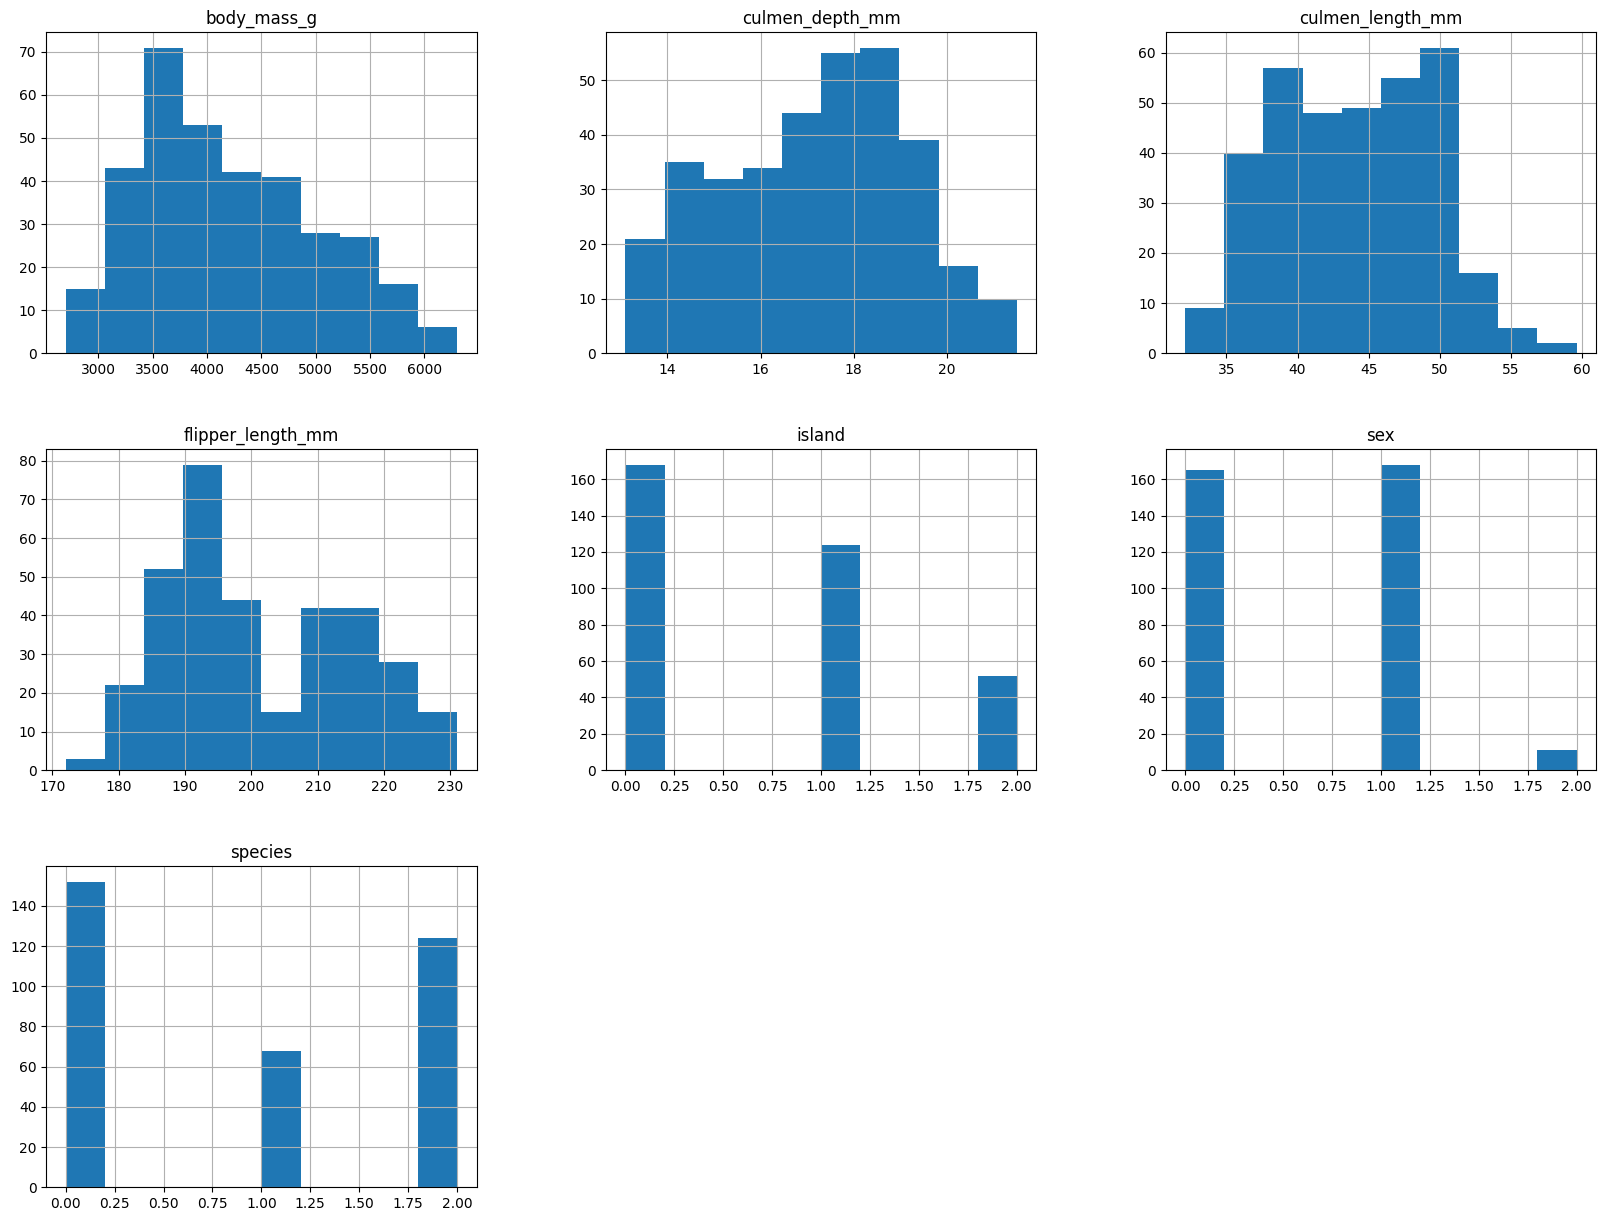

In [19]:
df.hist(figsize=(20,15))

<AxesSubplot: xlabel='body_mass_g', ylabel='culmen_length_mm'>

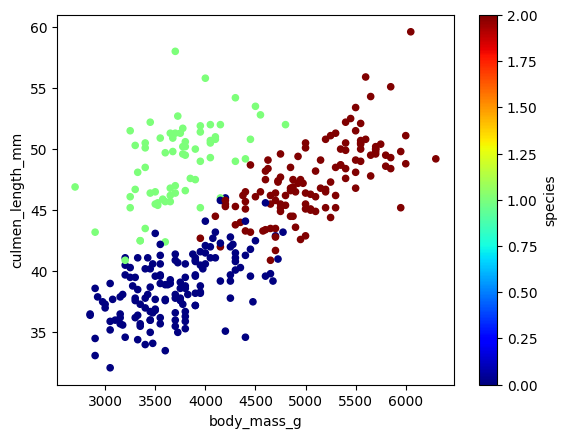

In [26]:
df.plot(kind="scatter", x="body_mass_g", y="culmen_length_mm", c="species", cmap="jet")

<AxesSubplot: xlabel='body_mass_g', ylabel='flipper_length_mm'>

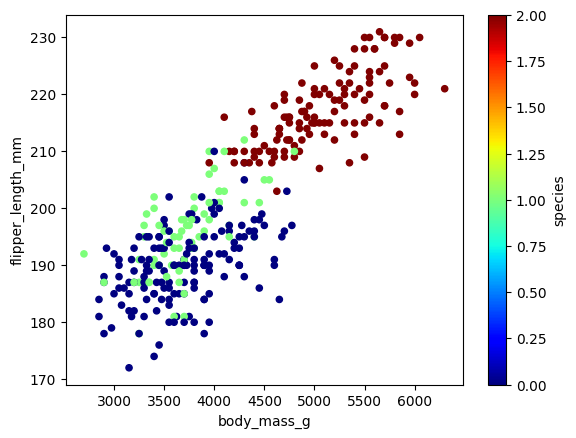

In [27]:
df.plot(kind="scatter", x="body_mass_g", y="flipper_length_mm", c="species", cmap="jet")

### Dimensionality Reduction

#### Clean Data

In [43]:
import pandas as pd
from sklearn.preprocessing import StandardScaler


numeric = df.dropna()[["body_mass_g", "culmen_depth_mm", "culmen_length_mm", "flipper_length_mm"]]
numeric.describe()

,body_mass_g,culmen_depth_mm,culmen_length_mm,flipper_length_mm
count,342.000000,342.000000,342.000000,342.000000
mean,4201.754395,17.151171,43.921932,200.915207
std,801.954529,1.974793,5.459584,14.061714
min,2700.000000,13.100000,32.099998,172.000000
25%,3550.000000,15.600000,39.225000,190.000000
50%,4050.000000,17.299999,44.450001,197.000000
75%,4750.000000,18.700001,48.500000,213.000000
max,6300.000000,21.500000,59.599998,231.000000


In [44]:
scaled = StandardScaler().fit_transform(numeric)
pd.DataFrame(scaled).describe()

,0,1,2,3
count,3.420000e+02,3.420000e+02,3.420000e+02,3.420000e+02
mean,2.788521e-09,2.230817e-08,-2.788521e-09,-1.394261e-08
std,1.001465e+00,1.001465e+00,1.001465e+00,1.001465e+00
min,-1.875362e+00,-2.054446e+00,-2.168527e+00,-2.059320e+00
25%,-8.138982e-01,-7.866353e-01,-8.615696e-01,-7.773731e-01
50%,-1.895079e-01,7.547510e-02,9.686540e-02,-2.788381e-01
75%,6.846384e-01,7.854496e-01,8.397669e-01,8.606704e-01
max,2.620248e+00,2.205397e+00,2.875868e+00,2.142618e+00


**NOTE**: Now all the data has a `mean ~= 0.0` and `std ~= 1.0`

### UMAP

In [45]:
import umap


reducer = umap.UMAP()
embeddings = reducer.fit_transform(scaled)

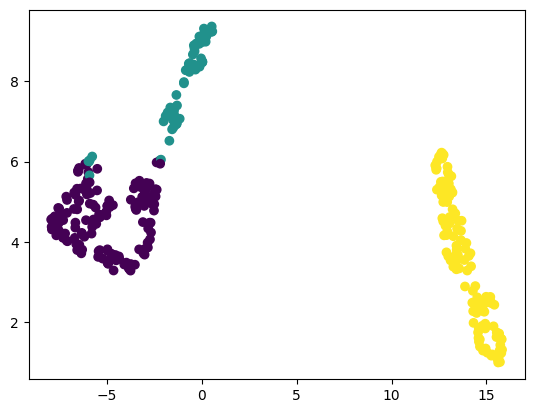

In [46]:
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=df.dropna()["species"])

### PaCMAP

In [47]:
import pacmap

reducer = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0)
embeddings = reducer.fit_transform(scaled)

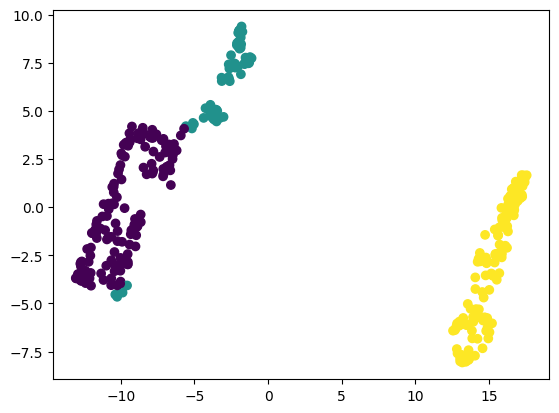

In [48]:
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=df.dropna()["species"])

### TriMAP

In [49]:
import trimap

reducer = trimap.TRIMAP()
embeddings = reducer.fit_transform(scaled)

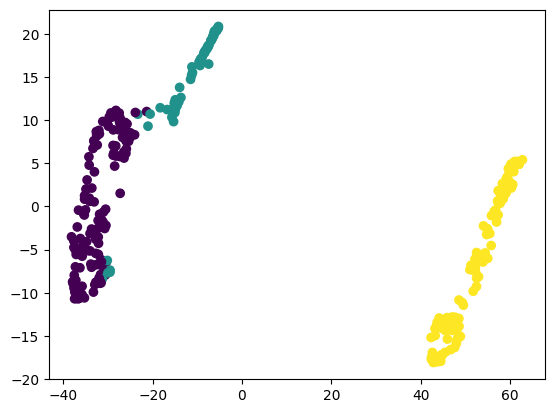

In [50]:
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=df.dropna()["species"])

### t-SNE

In [51]:
from sklearn.manifold import TSNE

reducer = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3)
embeddings = reducer.fit_transform(scaled)

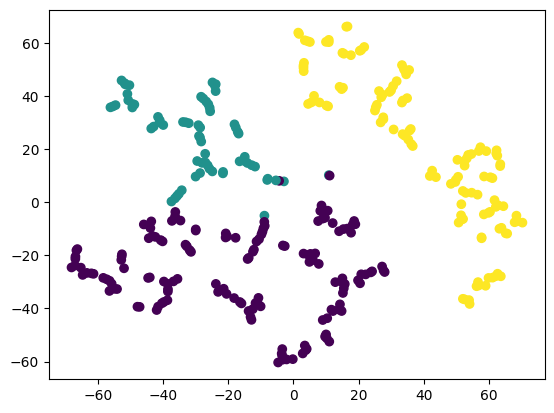

In [52]:
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=df.dropna()["species"])

## Get Real Data

In [54]:
data_split, info = tfds.load("penguins/processed", split=['train[:20%]', 'train[20%:]'], as_supervised=True, with_info=True)

In [72]:
data_test, data_train = data_split[0], data_split[1]
train_batch = data_train.batch(32)

#### Let's Preview Batch from Clean Dataset

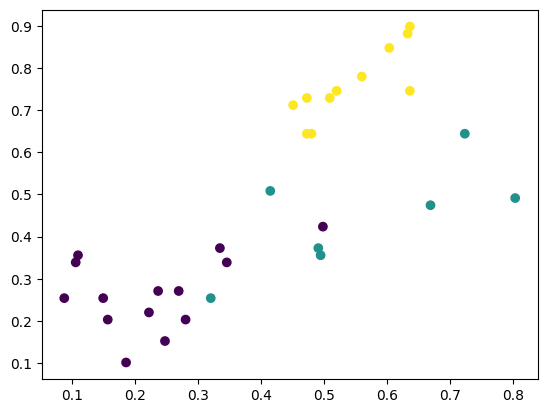

In [77]:
features, labels = list(train_batch)[0]
plt.scatter(features[:, 0], features[:, 2], c=labels, cmap='viridis')

# Define Model

![Network](https://www.tensorflow.org/tutorials/customization/images/full_network_penguin.png)

We simply create a linear stack of layers, with [relu](https://www.tensorflow.org/api_docs/python/tf/nn/relu) activation function. 

In [124]:
def make_model():
    return tf.keras.Sequential([
        tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),
        tf.keras.layers.Dense(10, activation=tf.nn.relu),
        tf.keras.layers.Dense(3, activation=tf.keras.activations.softmax),
    ])

model = make_model()

In [98]:
predictions = model(features)
predictions

<tf.Tensor: shape=(32, 3), dtype=float32, numpy=
array([[0.27338016, 0.32417017, 0.40244967],
       [0.32900116, 0.26934314, 0.40165573],
       [0.2560926 , 0.3083823 , 0.4355251 ],
       [0.2790018 , 0.33810908, 0.38288912],
       [0.265139  , 0.3675764 , 0.3672846 ],
       [0.2864388 , 0.2822646 , 0.43129662],
       [0.265029  , 0.29696664, 0.4380043 ],
       [0.27389452, 0.32131237, 0.40479308],
       [0.26145878, 0.34832335, 0.3902179 ],
       [0.29977104, 0.32072946, 0.37949947],
       [0.2808088 , 0.31379563, 0.40539557],
       [0.28919604, 0.34595013, 0.36485386],
       [0.2958402 , 0.32821873, 0.3759411 ],
       [0.2767545 , 0.35964012, 0.36360535],
       [0.28489515, 0.350732  , 0.36437282],
       [0.29975757, 0.2752042 , 0.42503828],
       [0.319568  , 0.27810064, 0.40233135],
       [0.31145635, 0.2683614 , 0.42018223],
       [0.2859121 , 0.33734268, 0.3767452 ],
       [0.27501756, 0.3565089 , 0.3684735 ],
       [0.27488953, 0.3628201 , 0.36229035],
      

In [108]:
list(zip(tf.math.argmax(predictions, axis=1).numpy(), labels.numpy()))

[(2, 0),
 (2, 2),
 (2, 1),
 (2, 0),
 (1, 0),
 (2, 1),
 (2, 1),
 (2, 1),
 (2, 0),
 (2, 1),
 (2, 1),
 (2, 0),
 (2, 0),
 (2, 0),
 (2, 0),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 0),
 (2, 0),
 (1, 0),
 (1, 0),
 (2, 2),
 (2, 2),
 (2, 1),
 (2, 2),
 (2, 0),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 0)]

# Train the Model

## Loss Function 

We use [Cross-Entropy](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#cross-entropy) as a loss function. 

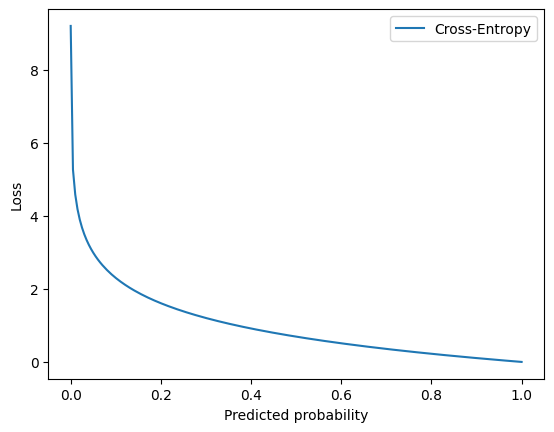

In [137]:
prob = tf.linspace(0.0001, 1.0, num=200)
cross_entropy = - tf.math.log(prob)
plt.plot(prob, cross_entropy, label="Cross-Entropy")
plt.xlabel("Predicted probability")
plt.ylabel("Loss")
plt.legend()
plt.show()

The Cross-Entropy computes a smooth loss value depending on the predicted probability and the actual class. The value is calculated as a negative log of the probability of the correct answer. 

$$ loss = - \sum^{M}_{c=1}y_{c}log(p_{c}) $$

Where $ y_c = 1$ if the correct class is `c` and $ y_c = 0 $ otherwise. So obviously $ loss \rightarrow \infty $ when probability of the correct class $ p_c \rightarrow 0 $. And $loss$ remains unchanged for all other classes. 

So this function is 
1. Differentiable, so we can calculated a gradient of the loss with respect to the trainable variables
2. The loss is very-very high when correct answer is predicted as unlikely

In [111]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

In [116]:
loss(y_true=labels, y_pred=model(features))

<tf.Tensor: shape=(), dtype=float32, numpy=1.1200066>

## Optimizer

Optimizer is a an algorithm for minimizing the loss function computed on the training set. Usually optimizers calculate a gradient of the loss with respect to the trainable variables using the [tf.GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) (API for auto-differentiation of the computed value) and then performs a *step* - meaning a change in the current value of the trainable variables.

![Optimizers](https://cs231n.github.io/assets/nn3/opt1.gif)

In this case we will use a [Stochastic gradient descen](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) (aka. SGD). The idea of the SGD is to use a random subset of the training set to compute the gradient on each step (which makes optimization less computationally instensive). 

In [118]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

## Training Loop

In [122]:
from dataclasses import dataclass, field
from typing import Sequence

def calc_gradient(model, inputs, expected_output, loss):
    with tf.GradientTape() as tape:
        loss_value = loss(
            y_true=expected_output,
            y_pred=model(inputs),
        )
    gradient = tape.gradient(loss_value, model.trainable_variables)
    return loss_value, gradient


@dataclass
class LearningHistory:
    loss: Sequence[float] = field(default_factory=list)
    accuracy: Sequence[float] = field(default_factory=list)

def train(model, train_batches, loss, optimizer, epochs=200) -> LearningHistory:
    history = LearningHistory()
    for epoch in range(epochs):
        epoch_loss_avg = tf.keras.metrics.Mean()
        epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
        for inputs, outputs in train_batches:
            l, gradients = calc_gradient(model, inputs, outputs, loss)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            
            epoch_loss_avg.update_state(l)
            epoch_accuracy.update_state(outputs, model(inputs, training=True))
        history.loss.append(epoch_loss_avg.result())
        history.accuracy.append(epoch_accuracy.result())
    return history

In [153]:
model = make_model()
epochs = 200
history = train(
    model=model,
    train_batches=train_batch,
    loss=loss, 
    optimizer=optimizer,
    epochs=epochs,
)

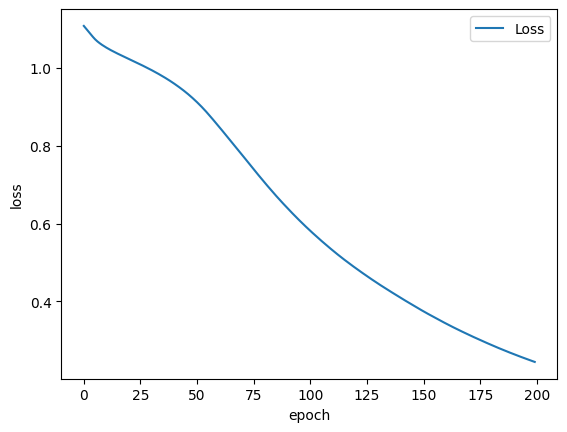

In [154]:
plt.plot(range(epochs), history.loss, label="Loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

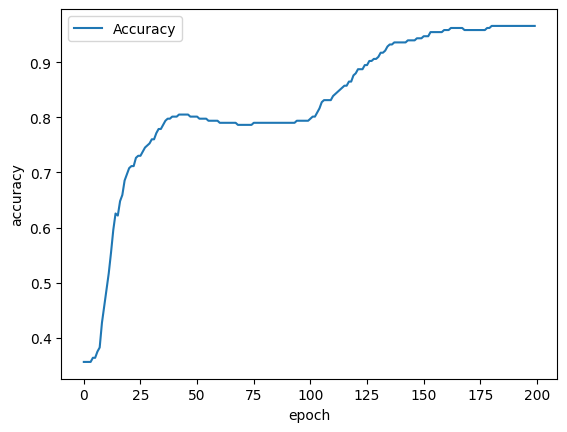

In [155]:
plt.plot(range(epochs), history.accuracy, label="Accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.show()

### Discussion

It is interesting to discuss the `Accuracy` curve. We can see that the value is very low, then sky-rocket to the ~0.8 and the remains flat. It has a plateau at some number of initial epochs and some number of ending epochs. 

What does it mean?

When we just started learning, almost all our predictions are incorrect. We rarely get correct answers just by chance. So the overall accuracy is not changing. **But how do we progress in this case? How do we decide in which direction to change our model in order to perform better? Whatever we do, we get a poor accuracy.**

When we answer correctly in most cases the accuracy jumps to the value of about `0.8`. In this case the correct answers already dominates (in a probability) the wrong answers. **But how do we progress further in this curcumstances? How do we become more confident in our correct answers, if accuracy is not sensitive to small changes anymore?**

The answer is **Cross-Entropy** loss-function! That's why we dont use negative accuracy as a loss function! As we can see from the loss function plot we gradually progressed all the time during the training. That's thanks to the smooth nature of the *Cross-Entropy* which is defined for all possible probabilities of the correct answer. **It remains sensitive to improvements even when most our answers are wrong or correct!** Because it take into account our confidence in the correct answer and it is very sensitive to even small improvements when we perform poorly ($ -log(p_c) \rightarrow \infty $ in this case.)

Hurray! I got it!
![Hurray!](https://kellsmurthwaite.files.wordpress.com/2007/12/hurray_1.jpg)

# Evaluate Results

In [156]:
accuracy = tf.keras.metrics.Accuracy()
test_batch = data_test.batch(32)

for inputs, outputs in test_batch:
    prediction = tf.math.argmax(model(inputs), axis=1, output_type=tf.int64)
    accuracy(prediction, outputs)

accuracy.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.9701493>

In [157]:
predict_dataset = tf.convert_to_tensor([
    [0.3, 0.8, 0.4, 0.5,],
    [0.4, 0.1, 0.8, 0.5,],
    [0.7, 0.9, 0.8, 0.4]
])

predictions = model(predict_dataset)
class_names = ['Adélie', 'Chinstrap', 'Gentoo']
for i, confidence in enumerate(predictions):
    print(f"Example {i}:")
    for cls, name in enumerate(class_names):
        print(f"\t{name}: {confidence[cls]:0.2f}")
    print("---\n")

Example 0:
	Adélie: 0.77
	Chinstrap: 0.19
	Gentoo: 0.04
---

Example 1:
	Adélie: 0.01
	Chinstrap: 0.02
	Gentoo: 0.97
---

Example 2:
	Adélie: 0.11
	Chinstrap: 0.77
	Gentoo: 0.12
---

